In [1]:
import pandas as pd
import numpy as np
import nltk
import contractions
import matplotlib.pyplot as plt

from string import punctuation
from collections import Counter
import seaborn as sns

In [2]:
import transformers

In [3]:
directory = r"C:\Users\sagar\OneDrive\Desktop\Sem 3\Deep Learning\Project Final\Data"


In [4]:

df_train = pd.read_csv(directory +"\LLM_vs_human_train_50k.csv")

In [5]:
df_val = pd.read_csv(directory +"\LLM_vs_human_val_1k.csv")

In [6]:
df_test = pd.read_csv(directory +"\LLM_vs_human_test_1k.csv")

In [7]:
df_combined=pd.concat([df_train,df_val,df_test],ignore_index=True)

In [8]:
df_combined

,Unnamed: 0,text,source,label
0,0,I'm not happy with what I've wrote to be hones...,Human,0
1,1,Postmodernist Anthropology and its Impact on T...,Human,0
2,2,"Firstly, is it okay to write an essay or does ...",Human,0
3,3,Nissan Company’s Operational Changes and Manag...,Human,0
4,4,I think some people might find visiting a nati...,Human,0
...,...,...,...,...
51995,995,The cybersecurity community is abuzz with the ...,GPT-3.5,1
51996,996,"As a language model AI, I cannot agree or disa...",GPT-3.5,1
51997,997,The night was falling on the western hemispher...,GPT-3.5,1
51998,998,The Pirate Bay (TPB) has been able to continue...,GPT-3.5,1


In [9]:
# !pip install tf-keras
import torch
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [10]:
from transformers import pipeline

# Initialize the sentiment analysis pipeline with the RoBERTa model
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment",device=0)
def predict_sentiment(text):
    results = sentiment_pipeline(text, truncation=True, max_length=512)

    # Initialize lists to hold sentiment labels and scores
    sentiments = []
    scores = []

    for result in results:
        # Map model-specific labels to standard sentiment labels
        label_map = {'LABEL_0': 'NEGATIVE', 'LABEL_1': 'POSITIVE', 'LABEL_2': 'NEUTRAL'}
        sentiment = label_map[result['label']]
        score = result['score']

        sentiments.append(sentiment)
        scores.append(score)

    # Aggregate the results for overall sentiment
    if sentiments:
        overall_sentiment = max(set(sentiments), key=sentiments.count)
    else:
        overall_sentiment = 'NEUTRAL'
    avg_score = sum(scores) / len(scores) if scores else 0.5

    return overall_sentiment, avg_score




In [ ]:
import concurrent.futures

def apply_sentiment_parallel(text):
    return predict_sentiment(text)

try:
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(apply_sentiment_parallel, df_combined['text']), total=len(df_combined), desc="Processing"))
    
    # Unzip the results
    overall_sentiments, avg_scores = zip(*results)
    
    # Assign the results to DataFrame columns
    df_combined['overall_sentiment'] = overall_sentiments
    df_combined['average_sentiment_score'] = avg_scores
except Exception as e:
    print(f"An error occurred: {e}")

Processing:  94%|████████████████████████████████████████████████████████████▏   | 48897/52000 [08:56<00:35, 88.63it/s]

In [13]:
df_combined

,Unnamed: 0,text,source,label
0,0,I'm not happy with what I've wrote to be hones...,Human,0
1,1,Postmodernist Anthropology and its Impact on T...,Human,0
2,2,"Firstly, is it okay to write an essay or does ...",Human,0
3,3,Nissan Company’s Operational Changes and Manag...,Human,0
4,4,I think some people might find visiting a nati...,Human,0
...,...,...,...,...
51995,995,The cybersecurity community is abuzz with the ...,GPT-3.5,1
51996,996,"As a language model AI, I cannot agree or disa...",GPT-3.5,1
51997,997,The night was falling on the western hemispher...,GPT-3.5,1
51998,998,The Pirate Bay (TPB) has been able to continue...,GPT-3.5,1


C:\Users\venka\AppData\Local\Temp\ipykernel_26796\1197318866.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=sentiment_counts_generated.index, y=sentiment_counts_generated.values, palette='coolwarm')
C:\Users\venka\AppData\Local\Temp\ipykernel_26796\1197318866.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=sentiment_counts_not_generated.index, y=sentiment_counts_not_generated.values, palette='coolwarm')


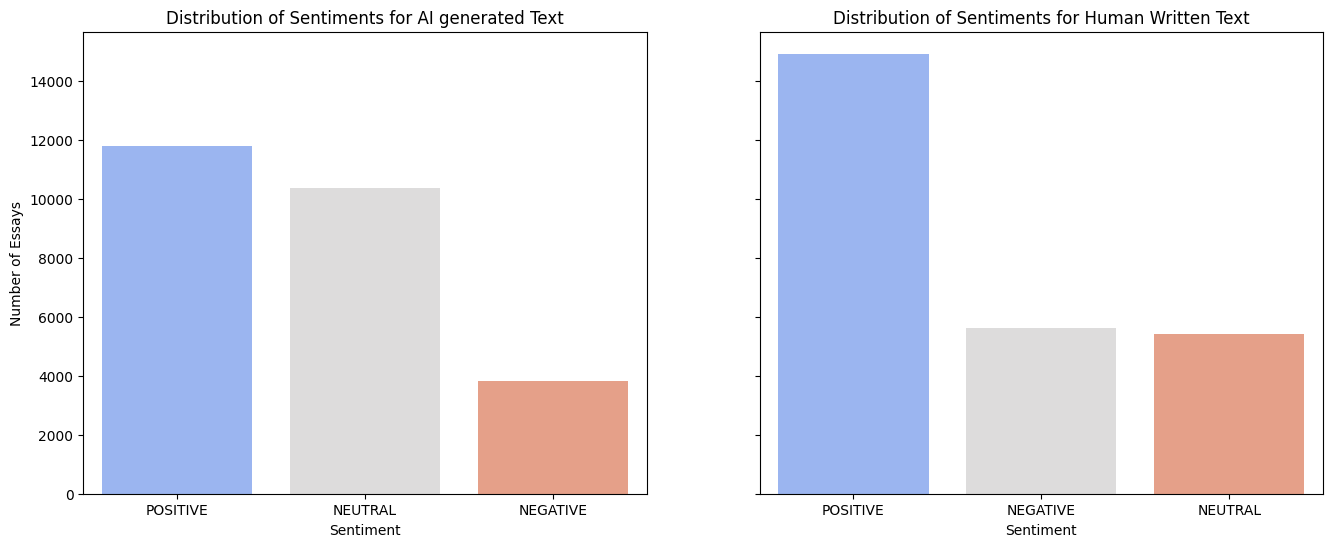

In [15]:

# Separate the dataframe into two based on the 'Generated' column
generated_df = df_combined[df_combined['label'] == 1]
not_generated_df = df_combined[df_combined['label'] == 0]

# Get the sentiment counts for both generated and not generated
sentiment_counts_generated = generated_df['overall_sentiment'].value_counts()
sentiment_counts_not_generated = not_generated_df['overall_sentiment'].value_counts()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Plot for generated
sns.barplot(ax=axes[0], x=sentiment_counts_generated.index, y=sentiment_counts_generated.values, palette='coolwarm')
axes[0].set_title('Distribution of Sentiments for AI generated Text')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Number of Essays')

# Plot for not generated
sns.barplot(ax=axes[1], x=sentiment_counts_not_generated.index, y=sentiment_counts_not_generated.values, palette='coolwarm')
axes[1].set_title('Distribution of Sentiments for Human Written Text')
axes[1].set_xlabel('Sentiment')
# The ylabel is shared, set by the first subplot

# Show the plot
plt.show()

In [25]:
import os

# Define the directory path
directory_sentiment_analysis = directory + "Sentiment_Analysis"
file_path = directory_sentiment_analysis + "//Sentiment_Analysis_Complete.csv"



In [28]:

# Check if the directory exists; if not, create it
os.makedirs(os.path.dirname(file_path), exist_ok=True)

# Save the DataFrame to CSV
df_combined.to_csv(file_path, index=False)